## Import Libraries

In [3]:
import numpy as np
import pandas as pd
    
import seaborn as sns
sns.set(style="darkgrid")

import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt

from date_processing_functions import (
    process_book_date, get_convertible_rows,
    get_date, remove_outliers_iqr, line_plot,
    get_seg_metrics, split_dates, encode_categoricals,
    strip_categoricals, ret_cross_table
)

import lightgbm as lgb 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

pd.set_option('max_columns', 999)

import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## Loading Dataset

In [4]:
df = pd.read_excel('data.xlsx',sheet_name='data')
df.head()

,Product,Lift Number,Ship Nomination,Qty MT,Load Port,Destination,Load Booking Date,Load Current,ETB Load Port,Destination Booking Date,Destination Current,Order 1st Layday,Order Cancel Date,Order Layday Extension,Status,Order Confirmed Date,Freight Invoice Number,Freight Due Date,Comments,Sales Order #,Shipment #,Voyage #,Cancelled
0,Product A,NaN,Bow Tone,3500,NaN,Rotterdam,2011-12-23 00:00:00,Loaded 12/31,NaN,2012-01-15 00:00:00,2012-01-25 00:00:00,2011-12-19,2011-12-28,NaT,F,2011-12-13,F-190052169-A,2012-01-19 00:00:00,NaN,741928.0,11021824,5,0
1,Product A,NaN,Selje,9000,NaN,Ningbo,2011-12-12 00:00:00,Loaded 12/23,NaN,2012-02-03 00:00:00,2012-02-07 00:00:00,2011-12-12,2011-12-26,NaT,F,2011-11-21,30200202,2012-01-13 00:00:00,NaN,736739.0,11011029,1,0
2,Product A,NaN,Stolt Focus,2000,NaN,Ningbo,2012-01-08 00:00:00,Loaded 1/17,NaN,2012-03-07 00:00:00,2012-03-14 00:00:00,2012-01-14,2012-02-03,NaT,F,2012-12-20,30200336,2012-02-07 00:00:00,NaN,741646.0,11021066,3A,0
3,Product A,NaN,Stolt Confidence,1780,NaN,Ningbo,2012-01-22 00:00:00,Loaded 1/30,NaN,2012-03-16 00:00:00,2012-03-29 00:00:00,2012-01-22,2012-02-11,NaT,F,2012-01-04,30200643,2012-02-21 00:00:00,t/s to Ningbo on the Stolt Avocet,744411.0,11027592,4,0
4,Product A,NaN,Stolt Topaz,4220,NaN,Ningbo,2012-01-26 00:00:00,loaded 2/11,NaN,2012-03-23 00:00:00,2012-03-26 00:00:00,2012-01-25,2012-02-14,NaT,F,2012-01-06,30200930,2012-03-03 00:00:00,completed Ningbo 29 Mar,NaN,NaN,5,0


## Processing Dataset

### Check if voyage was cancelled

In [5]:
df.loc[df['Load Current'].str.contains('cancelled', case=False, na=False),'Cancelled'] = 1
df = df[df['Cancelled']!=1].drop(columns='Cancelled')

### Preprocess 'Load Booking Date' and 'Destination Booking Date' features   

In [6]:
df['Load Booking Date'] = df.apply(lambda x: process_book_date(x, load=True), axis=1)
df['Destination Booking Date'] = df.apply(lambda x: process_book_date(x, destination=True), axis=1)

### Check which rows from 'Load Current' and 'Destination Current' might have date information

In [7]:
df = get_convertible_rows(df)

### Parsing 'Processed Load Current' and 'Processed Destination Current'
Cases that are preprocessed parsed by get_date

1)Standard date: case 16/04/2019  00:00:00

2)Partial date: year inference based on book date
    2.1 case loaded 2/1 
    2.2 case loaded 7-27
    2.3 case loaded 27 June
    2.4 case loaded 2 Aug
 
3) More than one day at date: case 4/1-5/13

In [8]:
df['Processed Load Current'] = df.apply(lambda x: get_date(x, load=True), axis=1)
df['Processed Destination Current'] = df.apply(lambda x: get_date(x, destination=True), axis=1)

### Percentage of date processed and checking missing date

In [9]:
df.replace('NaN', np.NaN, inplace=True)
df.replace('nan', np.NaN, inplace=True)

total = df.isnull().sum()
percent_1 = df.isnull().sum() / df.isnull().count() * 100
percent_2 = (round(percent_1, 2))
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.reset_index(inplace=True)
missing_data

,index,Total,%
0,Product,0,0.00
1,Lift Number,793,69.68
2,Ship Nomination,0,0.00
3,Qty MT,0,0.00
4,Load Port,518,45.52
5,Destination,0,0.00
6,Load Booking Date,5,0.44
7,Load Current,7,0.62
8,ETB Load Port,1043,91.65
9,Destination Booking Date,4,0.35


In [10]:
hold_data = (len(df) - missing_data['Total'].iloc[22])/(len(df)-missing_data['Total'].iloc[7])
print(f"Processing Load Current for date pattern hold {round(hold_data*100,2)}% of original data")
                                                       
hold_data = (len(df) - missing_data['Total'].iloc[23])/(len(df)-missing_data['Total'].iloc[10])
print(f"Processing Destination Current for date pattern hold {round(hold_data*100,2)}% of original data")

drop_columns = ['Destination Current','Load Current']
df = df.drop(columns=drop_columns)

Processing Load Current for date pattern hold 96.37% of original data
Processing Destination Current for date pattern hold 93.84% of original data


## Data Preprocessing

### Travel Time: Expected x Realized

- expected time : Destination Booking Date - Load Booking Date
- realized time: Processed Destination Current - Processed Load Current
- load delay: Processed Load Current - Load Booking Date
- destination_delay: Processed Destination Current - Destination Booking Date

In [11]:
#Select only rows with all information
columns = ['Destination Booking Date','Load Booking Date','Processed Destination Current','Processed Load Current']
dfTemp = df[columns].dropna()
dfTemp = pd.merge(df.drop(columns=columns), dfTemp, left_index=True, right_index=True, how='right')
dfTemp['expected time'] = (dfTemp['Destination Booking Date'] - dfTemp['Load Booking Date']).dt.days
dfTemp['realized time'] = (dfTemp['Processed Destination Current'] - dfTemp['Processed Load Current']).dt.days
dfTemp['load_delay'] = (dfTemp['Processed Load Current'] - dfTemp['Load Booking Date']).dt.days
dfTemp['destination_delay'] = (dfTemp['Processed Destination Current'] - dfTemp['Destination Booking Date']).dt.days

### Date columns preprocessing

In [12]:
dfTemp['Freight Due Date'] = pd.to_datetime(dfTemp['Freight Due Date'], errors='coerce')
dfTemp['Freight Invoice Number'] = LabelEncoder().fit_transform(dfTemp['Freight Invoice Number'].astype(str).to_numpy())
dfTemp = split_dates(dfTemp)
dfTemp = strip_categoricals(dfTemp)

## Data Analysis

### Distribution of Expected Time

It is possible to verify the presence of outliers. They are justified by typos in time of inputing data, e.g., line 17 in df, which corresponds to 19 in excel file.

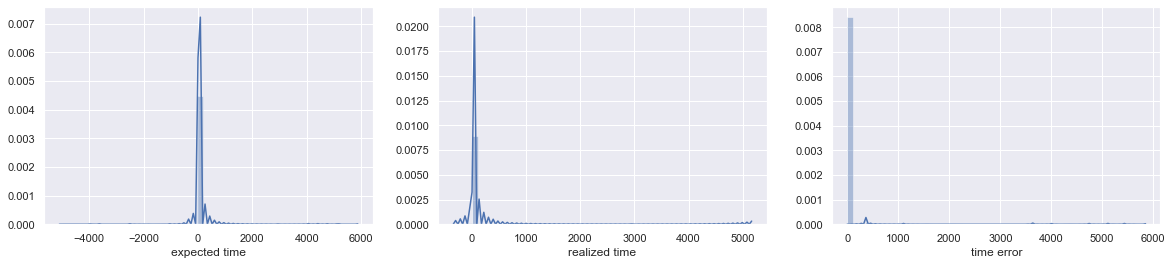

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
dfTemp['time error'] = abs(dfTemp['expected time']-dfTemp['realized time'])
dfTemp['before_expected'] = (dfTemp['expected time']-dfTemp['realized time']).apply(lambda x: 1 if x>0 else 0)
dfTemp['after_expected'] = (dfTemp['expected time']-dfTemp['realized time']).apply(lambda x: 1 if x<0 else 0)

ax = sns.distplot(dfTemp['expected time'], ax = axes[0])
ax = sns.distplot(dfTemp['realized time'], ax = axes[1])
ax = sns.distplot(dfTemp['time error'], ax = axes[2])

### Outliers Removal: Interquantil Range metrics 

1) IQR = Q3 – Q1.

2) Multiply the interquartile range (IQR) by 1.5 (a constant used to discern outliers).

3) Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.

4) Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

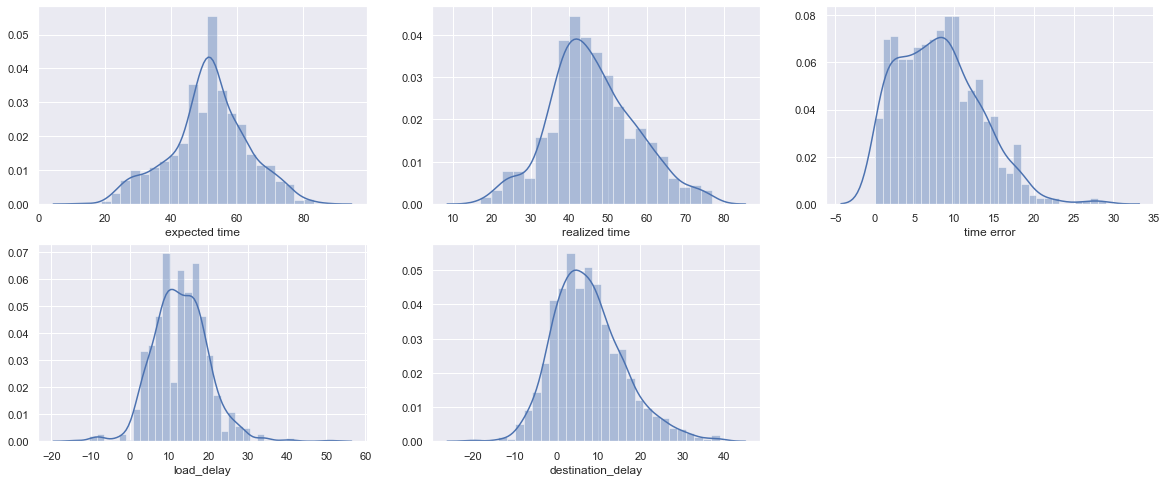

In [14]:
dfTemp = remove_outliers_iqr(dfTemp, column=['expected time','realized time'])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,8))

ax = sns.distplot(dfTemp['expected time'], ax = axes[0][0])
ax = sns.distplot(dfTemp['realized time'], ax = axes[0][1])
ax = sns.distplot(dfTemp['time error'], ax = axes[0][2], bins=30)
ax = sns.distplot(dfTemp['load_delay'], ax = axes[1][0])
ax = sns.distplot(dfTemp['destination_delay'], ax = axes[1][1])
fig.delaxes(axes[1][2])

### Univariate Analysis

Highlights provided by univariate analysis:
   
 - **Shortest travel** was completed in **19 days**
 - **Longest** travel was completed in **73 days**
 - Current expected book time is greater than the expected realized time, i.e., the **travels times** are **overestimated** by 12.1% in average**
 - **Average error** in time travel estimation is about **8 days** 

In [15]:
dfTemp[['expected time','realized time','time error','load_delay','destination_delay']].describe()

,expected time,realized time,time error,load_delay,destination_delay
count,857.000000,857.000000,857.000000,857.000000,857.000000
mean,51.352392,46.051342,7.989498,12.931155,7.630105
std,11.797036,11.125229,5.174401,6.914442,8.359877
min,13.000000,17.000000,0.000000,-14.000000,-20.000000
25%,45.000000,39.000000,4.000000,8.000000,2.000000
50%,52.000000,45.000000,8.000000,13.000000,7.000000
75%,59.000000,53.000000,11.000000,17.000000,12.000000
max,86.000000,77.000000,29.000000,51.000000,39.000000


Highlights provided by cumulative distribution function:
    
   * Prediction time: 77% of travel times have duration of 60 days.
   * Realized time: 76% of travel times have duration of 53 days.
   * Time error: 76% of error in travel times prediction has at most 11 days.
   * Load delay: 77% of load delay reaches until 17 days.

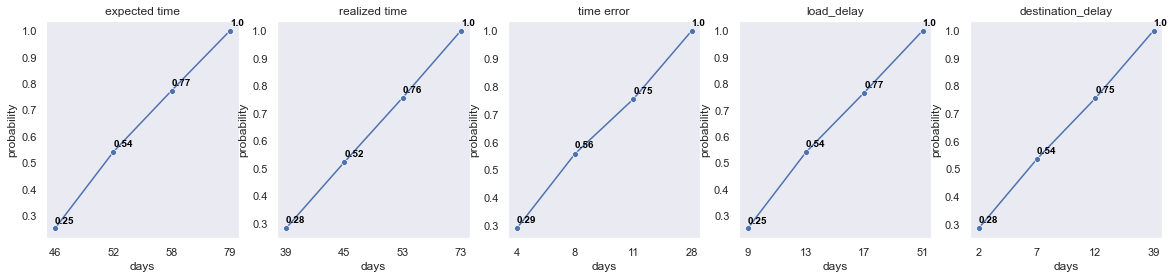

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
i = 0
label_dict = {
    'expected time':['46', '52', '58', '79'],
    'realized time':['39', '45', '53', '73'],
    'time error':['4','8','11','28'],
    'load_delay':['9','13','17','51'],
    'destination_delay':['2','7','12','39']
}
'destination_delay'
for column in ['expected time', 'realized time', 'time error','load_delay','destination_delay']:
    labels = label_dict[column]
    cdf = pd.qcut(
        dfTemp[column], 
        q =[0, 0.25, 0.5, 0.75, 1], 
        labels=labels).value_counts().to_frame().reset_index().sort_values(by=['index'])
    cdf['probability'] = cdf[column].cumsum()/cdf[column].sum()
    cdf.drop(columns=[column], inplace=True)
    cdf.rename(columns={'index':'days'}, inplace=True)
    
    ax = line_plot(df=cdf, x="days", y="probability", ax = axes[i], title=column)
    i+=1

### Segmentation Analysis

The analysis from product perspective indicates a slight greater time error estimation associated with Product B

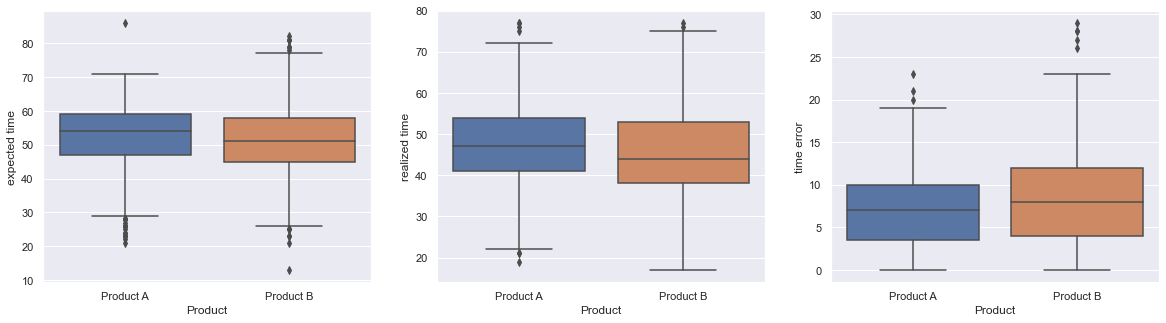

In [17]:
dfTemp.loc[dfTemp['Product'].str.contains('Product B'), 'Product'] = 'Product B'
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
sns.boxplot(x='Product', y='expected time', data=dfTemp, ax=axes[0])
sns.boxplot(x='Product', y='realized time', data=dfTemp, ax=axes[1])
sns.boxplot(x='Product', y='time error', data=dfTemp, ax=axes[2]);

- The **destinations** with the **smallest** travel time estimation error associated are **Rotterdam** and **Tees**, both locations have average **about five days** of error time estimation.
- The destinations with **higher degree of uncertainty** related with travel time estimation error are **Kobe/MSCC**, **Jubail**, **Caojing**, **Kobe/Asahi** with average greather than 12 days.

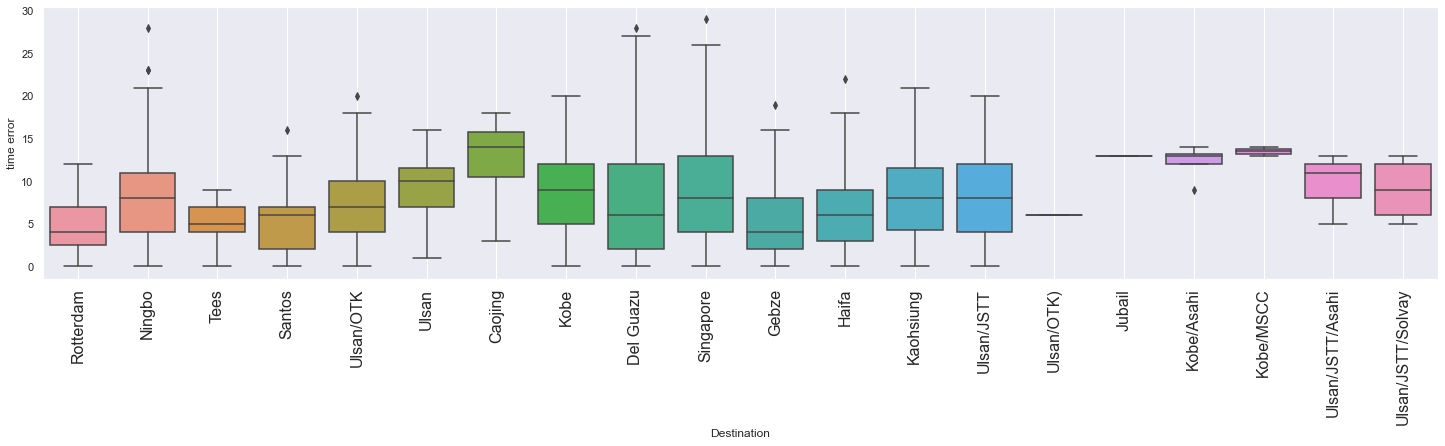

In [18]:
# display(dfTemp['Destination'].value_counts())
dfTemp.loc[dfTemp['Destination'].str.contains('Geb'),'Destination'] = 'Gebze'
fig, axes = plt.subplots(figsize=(25,5))
ships = dfTemp[['Destination', 'time error']]
plt.xticks(rotation=90, fontsize=16)
sns.boxplot(x='Destination', y='time error', data=ships);
axes.grid()


- The ships associated with **lowest error** in average travel time estimation are **Bow Spring**, **Chemstar Jewel**, **Chem Amsterdam** and **Chembulk Ulsan**. Their **expected travel time** and **realized travel time** were exactly the **same**, or very close each other.

- Among the ships which had the **largest error** in average travel time estimation are **Bow Sky**, **FPMC 27** and **Stolt Surf** with average time error estimation **close to 20 days**.

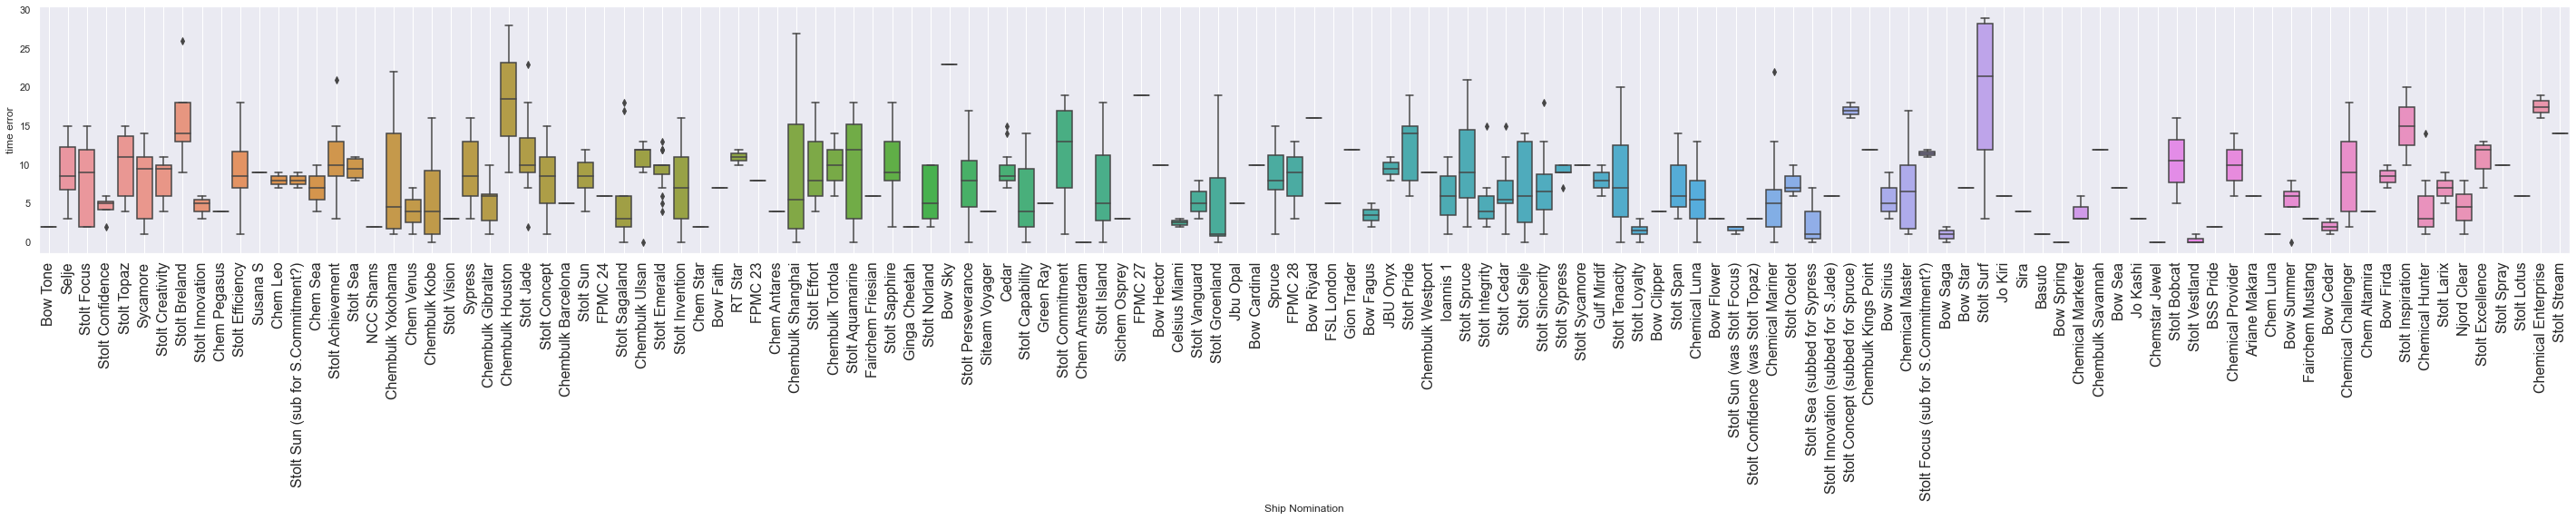

In [19]:
# display(dfTemp['Ship Nomination'].value_counts())
fig, axes = plt.subplots(figsize=(50,5))
ships = dfTemp[['Ship Nomination', 'time error']]
plt.xticks(rotation=90, fontsize=16)
sns.boxplot(x='Ship Nomination', y='time error', data=ships);
axes.grid()

Each **destination** seems to have very **different uncertainty degrees** on travel time estimation on average.
For instance, in Del Guazu, the average time error ship Basuto is close to zero, while it is about 25 days for ship named Chembulk.

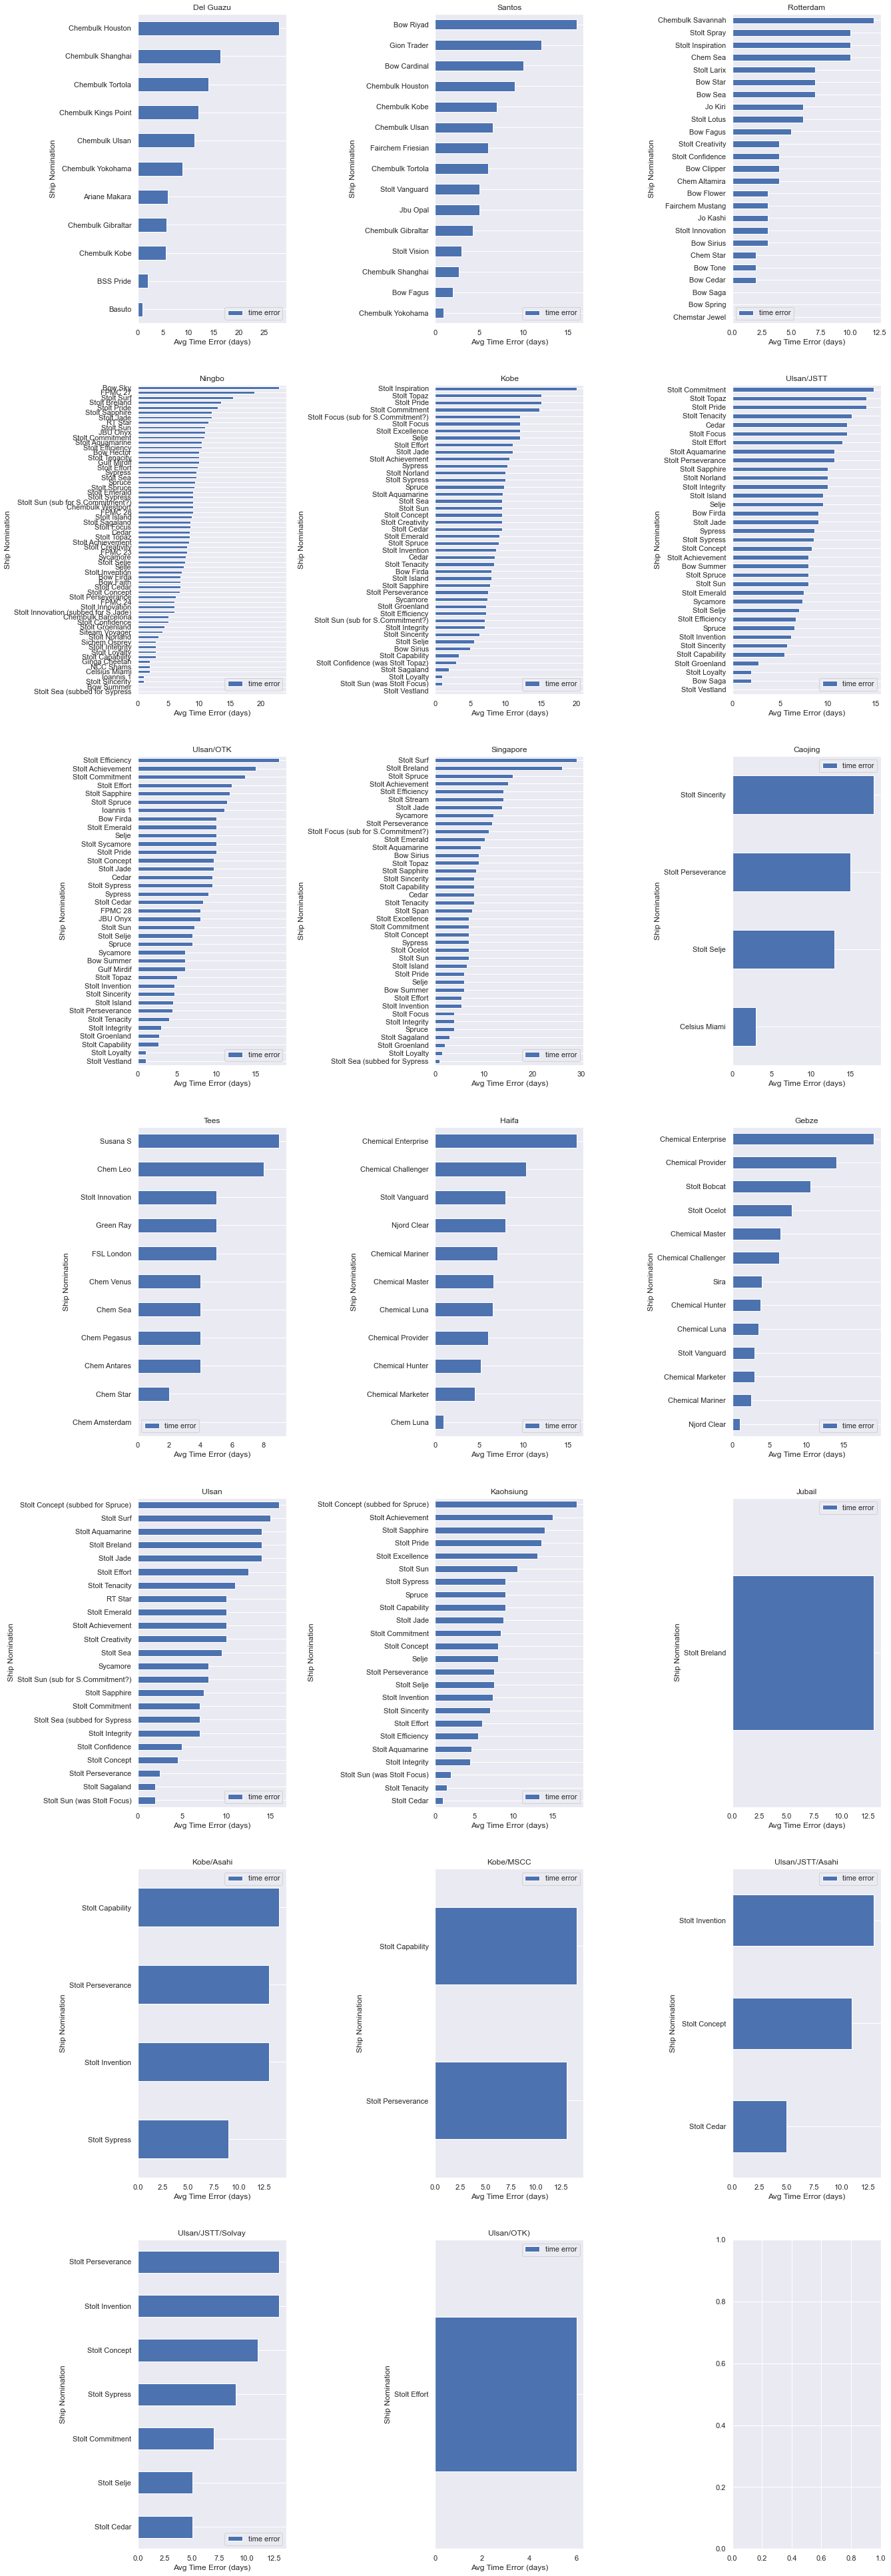

In [20]:
ship_destination = dfTemp[['Ship Nomination','Destination','time error']]\
    .groupby(['Ship Nomination','Destination'])\
    .agg({
        'time error':'mean'
    }).reset_index()


fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20,70))
plt.subplots_adjust(wspace=1, hspace=None)

destinations = ship_destination['Destination'].unique()

for i, d in enumerate(destinations):
    j = int(i/3)
    k = i % 3
    ship_destination[ship_destination['Destination'] == d]\
        .sort_values(by=['time error'])\
        .plot.barh(x= 'Ship Nomination', y='time error', ax=axes[j][k])
    axes[j, k].set_xlabel('Avg Time Error (days)')
    axes[j, k].grid(axis='x')
    axes[j, k].set_title(d)
    

Perfomance by destination of Top 12 lateness ship 

- The top 3 late ships have greater time errors associated with Ningbo destination. 
- Even that Ningbo doesn't appear in the worst overall destinantions, it has uncertainty with its travel time estimation which needs more deep exploration.

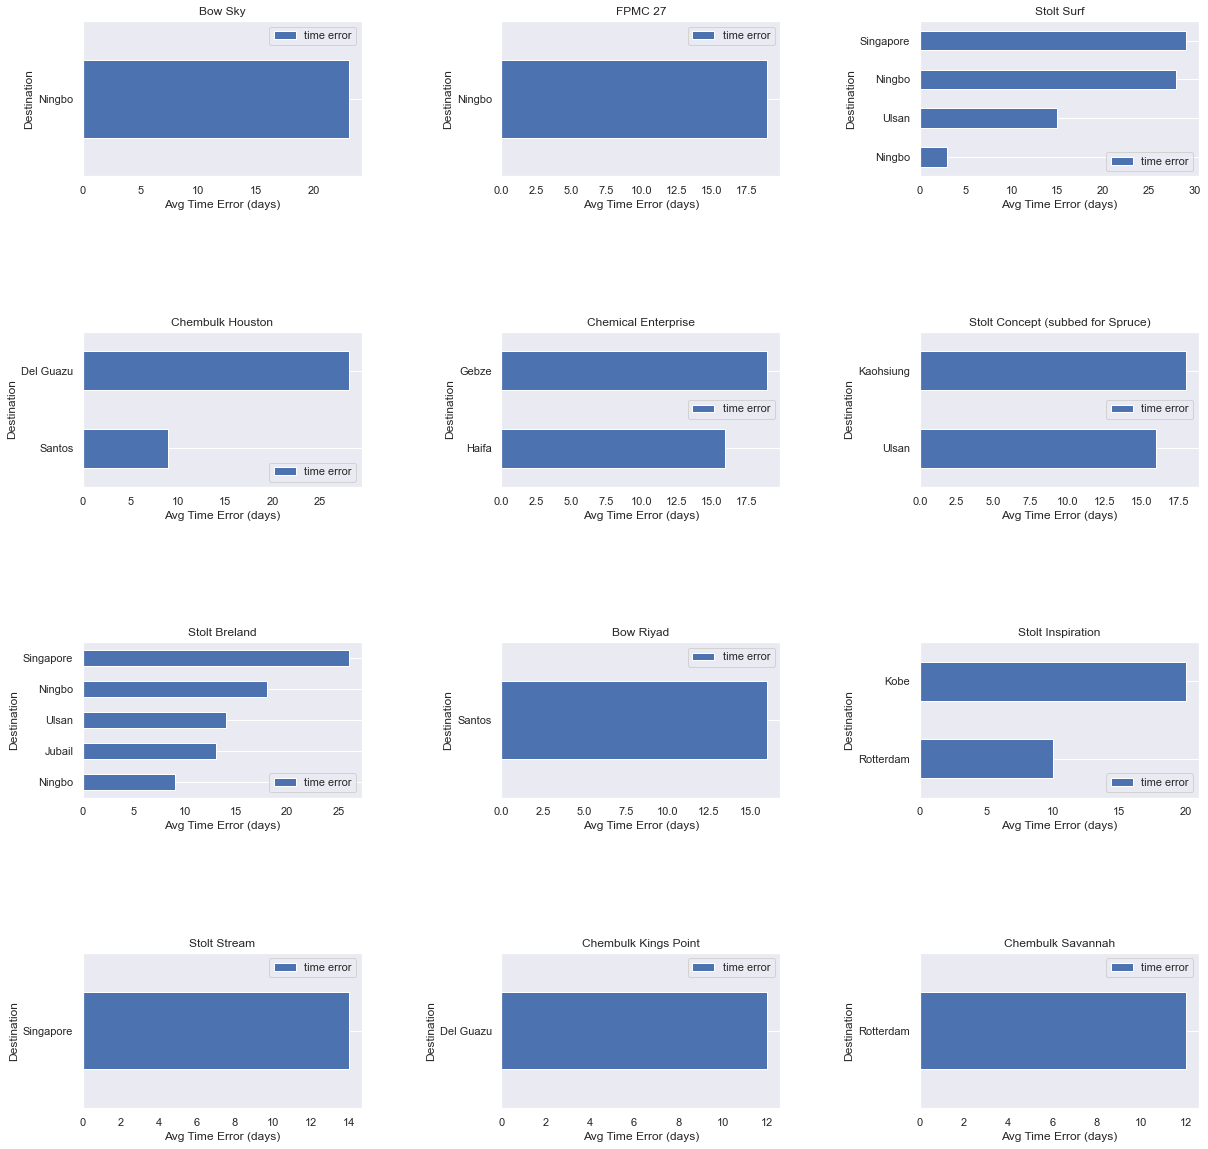

In [21]:
ship_destination = dfTemp[['Ship Nomination','time error']]\
    .groupby(['Ship Nomination'])\
    .agg({
        'time error':'mean'
    }).reset_index()

top_late_ships = ship_destination.sort_values(by='time error', ascending=False)[0:12]['Ship Nomination'].to_list()
ship_perf = dfTemp.loc[dfTemp['Ship Nomination'].isin(top_late_ships),['Destination','Ship Nomination','time error']]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20))
plt.subplots_adjust(wspace=0.5, hspace=1)

for i, s in enumerate(top_late_ships):
    j = int(i/3)
    k = i % 3
    ship_perf[ship_perf['Ship Nomination'] == s]\
        .sort_values(by=['time error'])\
        .plot.barh(x= 'Destination', y='time error', ax=axes[j][k])
    axes[j][k].set_xlabel('Avg Time Error (days)')
    axes[j][k].grid(axis='x')
    axes[j][k].set_title(s)

### Correlation Analysis

Verify correlation among numerical variables with time travel error estimation.

Highlights:

- The most positive correlations express clarify that more representatives delays are associated with ships arriving before expected date (expected time along with before_expected).
- The load_delay also has a positive correlation with time error expressing its influence in uncertainty about expected time prediction.
- Freight Due Date_dayofweek might indicates that day_of_week should be taken in account to travel time estimation (more study on this matter could provide policy for estimating according day_of_week)
- The most negative correlated feature (destination delay) also refers to early arriving ships (as sooner ships arrived, more negative is this value)

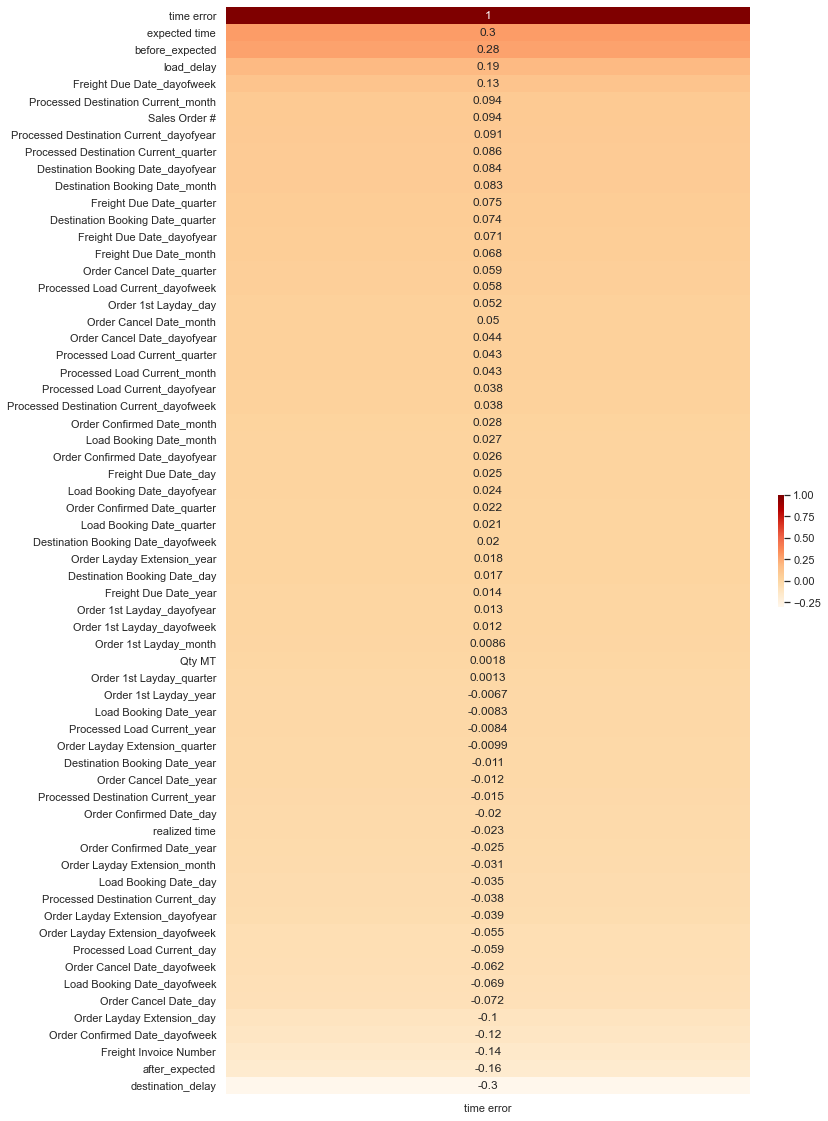

In [22]:
dfTemp_corr = dfTemp.select_dtypes(include=np.number).corr()

plt.figure(figsize=(10,20))
g = sns.heatmap(
    dfTemp_corr[['time error']].sort_values(by=['time error'],ascending=False),
    cbar_kws={'fraction' : 0.01},
    cmap='OrRd',
    annot=True
)

Just to confirm what correlation matrix is indicating, the number of trips which arrived before expected is plotted against trips which arrived destination after expected

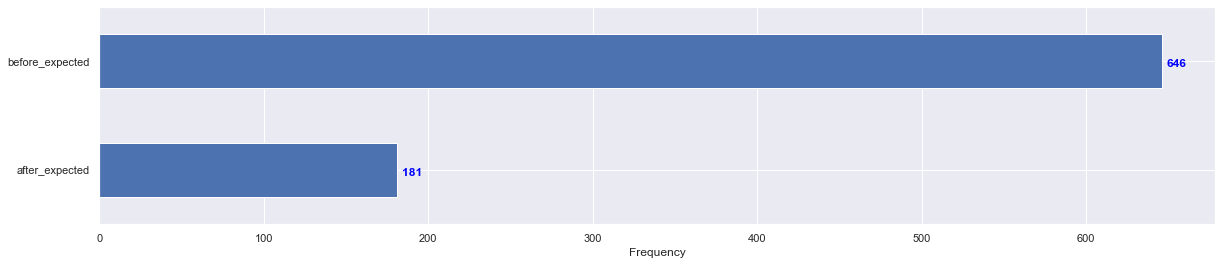

In [23]:
fig, axes = plt.subplots(nrows=1, figsize=(20,4))
d = dfTemp[['after_expected','before_expected']].sum()
d.plot.barh(ax=axes)
for i, v in enumerate(d.values):
    axes.text(v + 3, i - .05, str(v), color='blue', fontweight='bold')
axes.set_xlabel('Frequency');

### Scheduling Date analysis

- Using the below table is possible to see that in terms of frequency, the scheduling date also needs to be improved since most part of the booked load date and booked destination date do not happen as predicted.

- The reason for having most part of late_load and late_arrive, even with realized travel time lower than expected travel time, is that the load_delay shifts travel time window forward so that the ships usually arrive after destination book date even taking less time than planned.

- Load delay is bigger than destination delay increasing number of late_load and late_arrive

In [82]:

d = dfTemp[['time error','load_delay','destination_delay']]
cross_table = ret_cross_table(d)
cross_table = cross_table.apply(lambda x: round(x/cross_table.values.sum()*100,2))
cross_table
# fig, axes = plt.subplots(nrows=1, figsize=(7,5))
# ax = sns.heatmap(cross_table, 
#                  annot=True, 
#                  fmt='.3g',
#                  vmin=0, 
#                  vmax=20,
#                  cbar_kws={'fraction' : 0.1, 'orientation': 'horizontal'}, 
#                  cmap='OrRd')
# ax.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
# ax.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 12);

,early_arrive,timely_arrive,late_arrive
early_load,0.47,0.35,0.70
timely_load,0.00,0.12,0.00
late_load,14.70,3.73,79.93


## Modeling

### Split among train+validation and test

In [70]:
## Remove columns with more than 50% of missing values from modelling
## Remove Destination Current because this information will not be available in prediction time
## Remove Processed information used in data analysis
columns=['Lift Number', 'ETB Load Port', \
         'Sales Order #', 'Shipment #', 'Voyage #',  \
         'destination_delay', 'time error', \
         'before_expected', 'after_expected', 'realized time',\
         'Comments', 'Status','expected time','Freight Invoice Number']

## Remove date columns which will not be used
date_column = [
        x for x in dfTemp.columns 
        if x.startswith('Processed Destination Current_')
            or x.startswith('Order Layday Extension_') ]
columns.extend(date_column)
X = dfTemp.drop(columns=columns)

## Label Encoding and One hot enconding of categorical features
X = encode_categoricals(X)
y = dfTemp['realized time']

### Model training based on Root mean squared error (RMSE)

MSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.

RMSE gives a relatively high weight to large errors in comparison with MAE

$RMSE= \sqrt{ \frac{1}{N}\sum_{i=1}^{N} (θ_i-\hat{θ}_i)^2}$

In [73]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# evaluate the model
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
RMSE = list(map(lambda x: np.sqrt(-x),n_scores))
print(f'Model Avg RMSE: {np.mean(RMSE):.3f} days ({np.std(RMSE):.3f})')
print(f'Realized Avg Error: {dfTemp["time error"].mean():.3f} days ({dfTemp["time error"].std():.3f})')
print(f"Error Reduction: {round(1-(np.mean(RMSE)/dfTemp['time error'].mean()),4)*100}%")

Model Avg RMSE: 5.852 days (0.680)
Realized Avg Error: 7.989 days (5.174)
Error Reduction: 26.75%



### Test Dataset Analysis

In [74]:
X['expected time'] = dfTemp['expected time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# fit the model on the whole dataset
model = LGBMRegressor()
model.fit(X_train.drop(columns='expected time'), y_train)

# make a single prediction
yhat = model.predict(X_test.drop(columns='expected time'))
print(f'True Value: {y_test.iloc[0]} days')
print(f'Current Prediction: {X_test["expected time"].iloc[0]} days')
print(f'Model Prediction: {int(yhat[0])} days')

True Value: 43 days
Current Prediction: 50 days
Model Prediction: 46 days


In [75]:
results = pd.concat([y_test,X_test['expected time']], axis=1).reset_index().drop(columns='index')
results['predicted'] = np.array(list(map(int, yhat)))

### RMSE Comparison

In [76]:
RMSE_Current = round(np.sqrt(mean_squared_error(results['expected time'], results['realized time'])),2)
RMSE_Model = round(np.sqrt(mean_squared_error(results['expected time'], results['predicted'])),2)
print(f"The RMSE observed by current prediction is: {RMSE_Current} days")
print(f"The RMSE provided by model prediction is: {RMSE_Model} days")
print(f"Error Reduction: {round(1-(RMSE_Model/RMSE_Current),4)*100}%")

The RMSE observed by current prediction is: 9.61 days
The RMSE provided by model prediction is: 9.05 days
Error Reduction: 5.83%


### Current prediction x Model prediction: Error Estimation

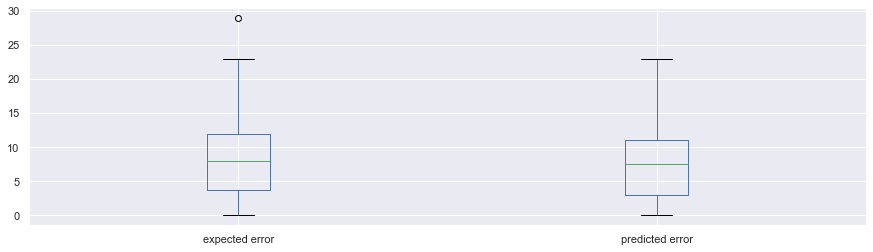

In [77]:
fig, axes = plt.subplots(figsize=(15,4))

results['expected error'] = abs(results['expected time'] - results['realized time'])
results['predicted error'] = abs(results['expected time'] - results['predicted'])
results[['expected error','predicted error']].boxplot(ax=axes);

### Model Feature Importance

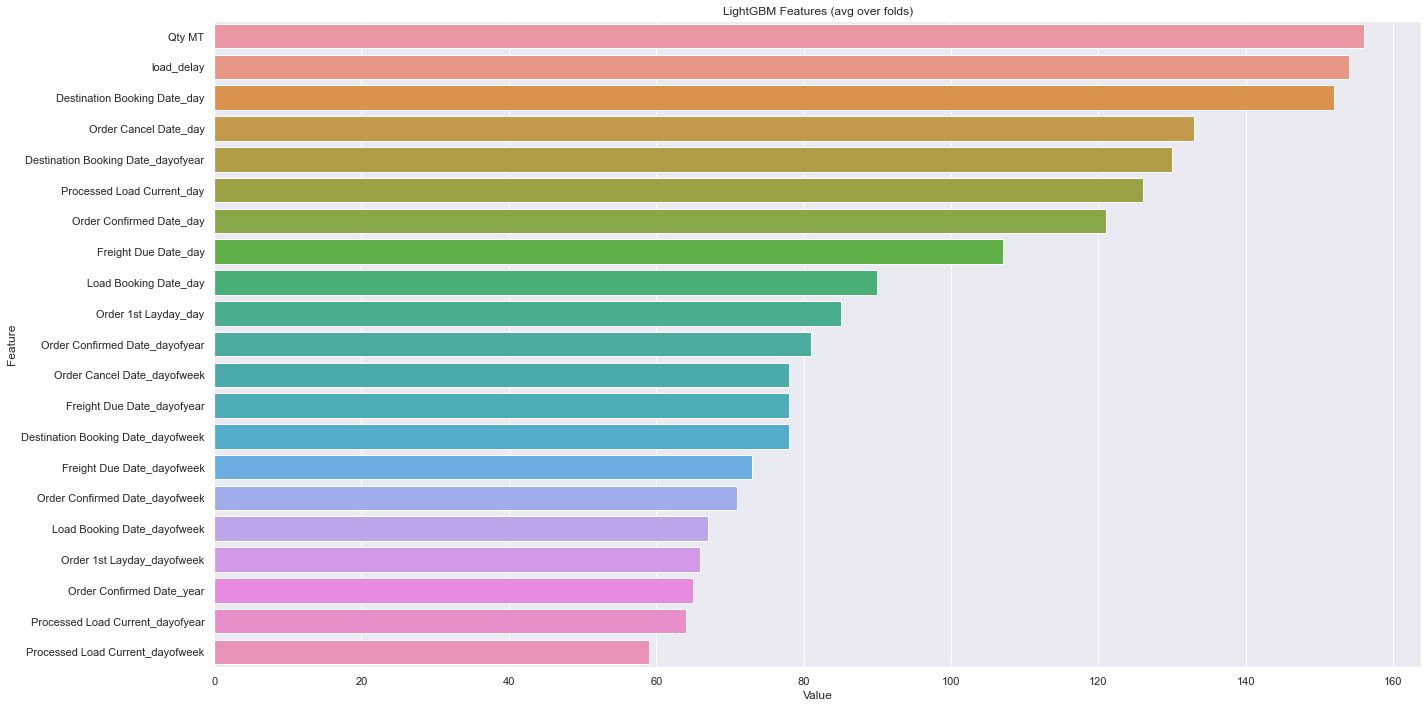

In [78]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])
feature_imp= feature_imp[feature_imp['Value']>40]
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)', fontsize=12)
plt.tight_layout()
plt.show()

## Next Steps

- Hyperparameter optimization
- Feature Engineering
- Application of other regression models (ElasticNet, Ridge Regression, Neural Network)
- Extend Temporal Analysis (Sazonality) 
- Temporal performance by destination, ship
- Perform Season Analysis 
- Transform in Classification Model, defining categories of delay 
- Shap values for extract more insights in feature importance analysis